In [ ]:
! pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

In [ ]:
from zipfile import ZipFile
dataset = '/content/breast-ultrasound-images-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

In [ ]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import random

In [ ]:
path = '../content/Dataset_BUSI_with_GT'

data_dir = pathlib.Path(path)

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

In [ ]:
benignPath = os.path.join(data_dir,'bening')
malignantPath = os.path.join(data_dir,'malignant')
normalPath = os.path.join(data_dir,'normal')

In [ ]:
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(class_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.png"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)

In [ ]:
from pathlib import Path
import imghdr

data_dir = '../content/Dataset_BUSI_with_GT'
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
                  data_dir,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)


val_data = image_dataset_from_directory(data_dir,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        image_size=(img_height,img_width),
                                        batch_size=batch_size)

In [ ]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3,activation="softmax")
])

In [ ]:
model.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

In [ ]:
epochs = 20
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data,
                    batch_size=batch_size)

In [ ]:
history.history.keys()

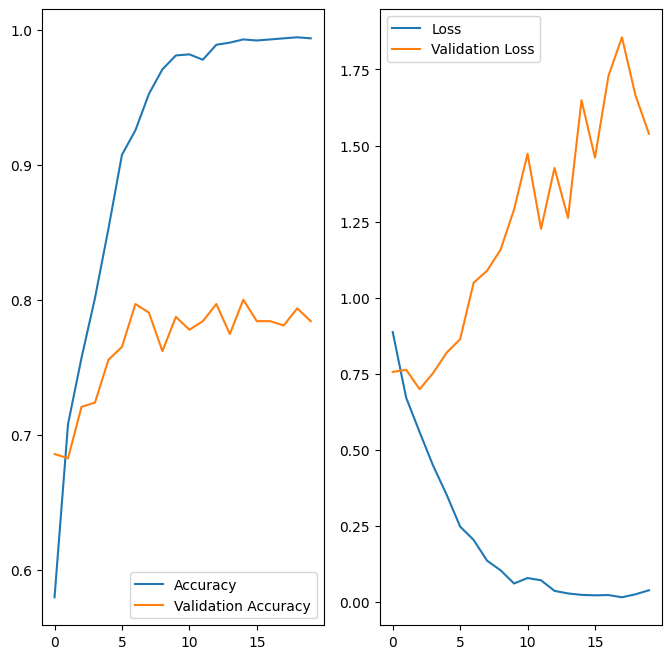

In [ ]:
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(val_data)

In [ ]:
model.summary()

In [ ]:
plt.figure(figsize=(20, 20))
class_names = val_data.class_names
result = ' F'
for images, labels in val_data.take(1):
    for i in range(25):

        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)

        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' T'

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")